In [1]:
# Imports

import matplotlib.pyplot as plt
from ptsnet.simulation.sim import PTSNETSimulation
from ptsnet.utils.io import get_example_path

## Simulation Settings
Simulation settings can be defined using a dictionary. We show below the default simulation settings.

In [2]:
default_settings = {
    "time_step" : 0.01, # Simulation time step in [s]
    "duration" : 20, # Simulation duration in [s]
    "period" : 0, # Simulation period for EPS
    "default_wave_speed" : 1000, # Wave speed value for all pipes in [m/s]
    "wave_speed_file_path" : None, # Text file with wave speed values
    "delimiter" : ',', # Delimiter of text file with wave speed data | pipe,wave_speed_value
    "wave_speed_method" : 'optimal', # Method to compute the wave speed adjustment
    "save_results" : True, # Saves numerical results in HDF5 format
    "skip_compatibility_check" : False, # Dismisses the compatibility check to run a faster initialization
    "show_progress" : False, # Shows progress (Warnings should be off)
    "profiler_on" : False, # Measures computational times of the simulation
    "warnings_on" : False
}

## Running a Simulation
The function `PTSNETSimulation` creates a new PTSNET simulation that reads an input file (.inp) located in the path `inpfile` and parses it. Users can use the test cases provided by the library which include:
`["B0", "B0_SURGE", "B1_0", "B3", "B0_0", "B1_1", "B4", "PIPE_IN_SERIES", "TNET3", "B0_1", "B2", "LOOP"]`. Paths to the test cases can be extracted using the `get_example_path(ex_name)` function.

In [3]:
# Create a simulation
sim = PTSNETSimulation(
    inpfile = get_example_path('TNET3'),
    settings = default_settings # If settings are not defined, default settings are loaded automatically
)
print(sim)

PTSNETSimulation <duration = 20 [s] | time_steps = 2617 | num_points = 5,098>


## Valve Closure
Users can manipulate specific valves of the system via the `define_valve_operation` function. The function allows to manipulate one or many pipes (e.g., `sim.all_pipes`). By default the closure occurs linearly varying the setting of the valve.

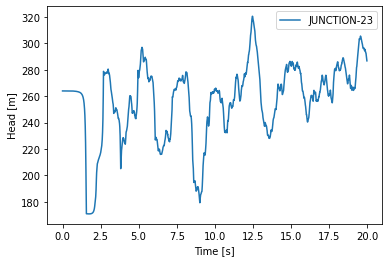

In [4]:
sim = PTSNETSimulation(inpfile = get_example_path('TNET3'))
sim.define_valve_operation('VALVE-179', initial_setting=1, final_setting=0, start_time=0, end_time=1)
sim.run()

# Plot results
plt.plot(sim['time'], sim['node'].head['JUNCTION-23'], label='JUNCTION-23')
plt.xlabel('Time [s]'); plt.ylabel('Head [m]')
plt.legend()
plt.show()

## Pump shut-off
Users can shut-off pumps using the `define_pump_operation`. By default the shut-off occurs linearly varying the setting of the pump.

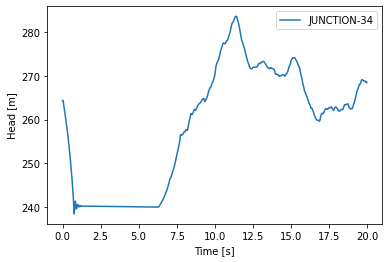

In [14]:
sim = PTSNETSimulation(inpfile = get_example_path('TNET3'))
sim.define_pump_operation('PUMP-172', initial_setting=1, final_setting=0, start_time=0, end_time=2)
sim.run()

# Plot results
plt.plot(sim['time'], sim['node'].head['JUNCTION-34'], label='JUNCTION-34')
plt.xlabel('Time [s]'); plt.ylabel('Head [m]')
plt.legend()
plt.show()

## Open Surge Tanks
We generate a transient by closing all the system's valves in 1 s. We add an open surge protection on node N7, with cross-section area, $A_T = 0.1$ $\text{m}^2$

In [6]:
sim = PTSNETSimulation(inpfile = get_example_path('TNET3'))
sim.define_pump_operation('PUMP-172', initial_setting=1, final_setting=0, start_time=0, end_time=1)
sim.add_surge_protection('JUNCTION-34', 'open', 0.1)
sim.run()


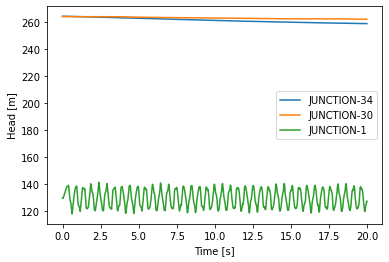

In [7]:
plt.plot(sim['time'], sim['node'].head['JUNCTION-34'], label='JUNCTION-34')
plt.plot(sim['time'], sim['node'].head['JUNCTION-30'], label='JUNCTION-30')
plt.plot(sim['time'], sim['node'].head['JUNCTION-1'], label='JUNCTION-1')
plt.xlabel('Time [s]')
plt.ylabel('Head [m]')
plt.legend()
plt.show()

## Closed Surge Tanks
We generate a transient by closing all the system's valves in 1 s. We add an closed surge protection on node N7, with cross-section area $A_T = 0.1 \text{ m}^2$, height $H_T = 1 \text{ m}$, and initial water level $H_W = 0.2\text{ m}$.

In [8]:
sim = PTSNETSimulation(inpfile = get_example_path('TNET3'))
sim.define_pump_operation('PUMP-172', initial_setting=1, final_setting=0, start_time=0, end_time=1)
sim.add_surge_protection('JUNCTION-34', 'closed', 0.1, 1, 0.2)
sim.run()

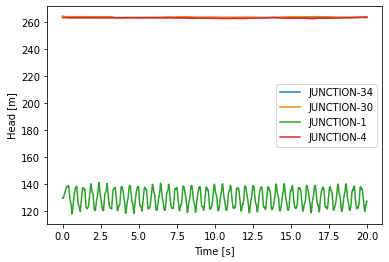

In [9]:
plt.plot(sim['time'], sim['node'].head['JUNCTION-34'], label='JUNCTION-34')
plt.plot(sim['time'], sim['node'].head['JUNCTION-30'], label='JUNCTION-30')
plt.plot(sim['time'], sim['node'].head['JUNCTION-1'], label='JUNCTION-1')
plt.plot(sim['time'], sim['node'].head['JUNCTION-4'], label='JUNCTION-4')
plt.xlabel('Time [s]')
plt.ylabel('Head [m]')
plt.legend()
plt.show()

## Leaks
Leaks can only be modeled as emitters via the .inp file

## Bursts
Users can add bursts defining `start_time` and `end_time` values which define how the burst is going to develop. Users have to define the final loss coefficient associated with the burst.

In [10]:
sim = PTSNETSimulation(inpfile = get_example_path('TNET3'), settings={'duration':20})
sim.add_burst('JUNCTION-90', 0.02, 0, 1)
sim.run()

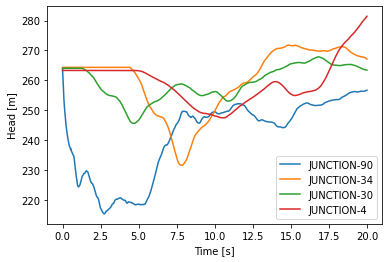

In [11]:
plt.plot(sim['time'], sim['node'].head['JUNCTION-90'], label='JUNCTION-90')
plt.plot(sim['time'], sim['node'].head['JUNCTION-34'], label='JUNCTION-34')
plt.plot(sim['time'], sim['node'].head['JUNCTION-30'], label='JUNCTION-30')
plt.plot(sim['time'], sim['node'].head['JUNCTION-4'], label='JUNCTION-4')
plt.xlabel('Time [s]')
plt.ylabel('Head [m]')
plt.legend()
plt.show()

## Analytics

The following scripts show analytics functionalities that can be used to determine:
1. Wave speed errors
2. Best number of processors for a particular application
3. Estimate simulation times before running the transient simulation